# Segment Anything Model: automatic mask generation using `transformers` 🤗 library

This notebook demonstrates how to use the Segment Anything Model (SAM) to automatically generate segementation masks on any image. The model was released by Meta AI in the paper [Segment Anything Model](https://ai.facebook.com/research/publications/segment-anything/). The original source code can be found [here](https://github.com/facebookresearch/segment-anything)

The `mask-generation` pipeline, freshly released for SAM, creates a gris of `1024` which are feed in a batch of `points_per_batch` to the model. The examples are inspired from the [original notebook of the authors](https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb).


## Utility functions

Run the cells below to import the needed utility functions for displaying the masks!

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import gc

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    del mask
    gc.collect()

def show_masks_on_image(raw_image, masks):
    plt.imshow(np.array(raw_image))
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for idx, mask in enumerate(masks):
        show_mask(mask, ax=ax, random_color=True)
        # Add mask index label at the top-left corner of each mask
        ys, xs = np.where(mask)
        if len(xs) > 0 and len(ys) > 0:
            min_x, min_y = xs.min(), ys.min()
            ax.text(min_x, min_y, str(idx), color='white', fontsize=8, weight='bold', va='top', ha='left', bbox=dict(facecolor='black', alpha=0.5, pad=0))
    plt.axis("off")
    plt.show()
    del mask
    gc.collect()

## Model loading

Use the `from_pretrained` method on the `SamForMaskGeneration` class to load the model from the Hub! For the sake of this demonstration we will use the `vit-huge` checkpoint.

In [2]:
from transformers import pipeline
generator = pipeline("mask-generation", model="facebook/sam-vit-huge", device=0)

2025-09-24 17:13:41.237399: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-24 17:13:41.245196: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758726821.253773   19823 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758726821.256314   19823 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758726821.263828   19823 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Load the example image

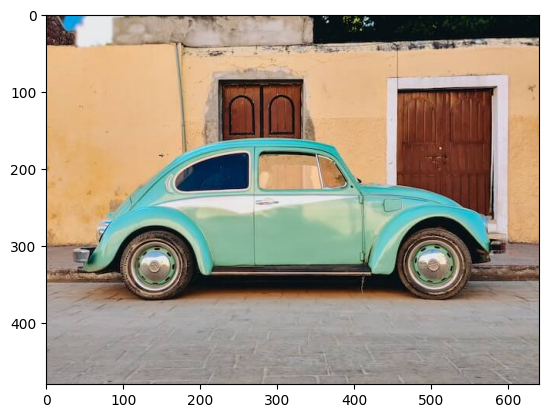

In [3]:
from PIL import Image
import requests

img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/car.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

plt.imshow(raw_image)

# Generate the masks


Let's automatically generate the masks on the image! For that simply pass the raw image into the generator 

In [4]:
outputs = generator(raw_image, points_per_batch=64)

The line above you take ~7 seconds on Google Colab 1xNVIDIA-T4, now let's see the resulting segmentation masks.

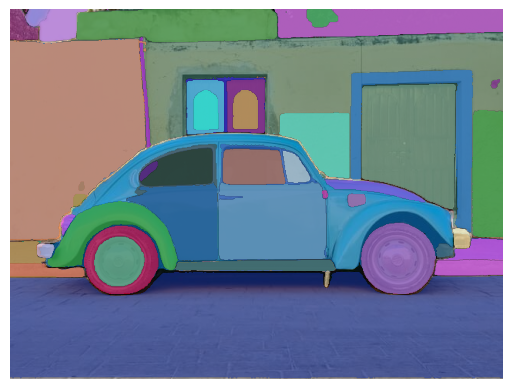

In [5]:
masks = outputs["masks"]
show_masks_on_image(raw_image, masks)

# Batch of images
You can feed both urls and raw images. Here is an example:

In [8]:
# new_image_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/depth-estimation-example.jpg"
new_image_path = "/home/robolab2/master_project/playground/gamma_corrected.png"
outputs = generator(new_image_path, points_per_batch=64)

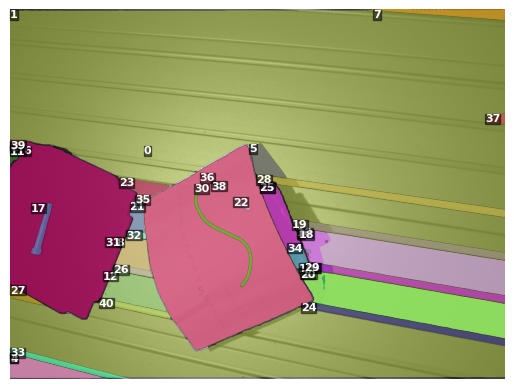

In [12]:
masks = outputs["masks"]
raw_image = Image.open(new_image_path).convert("RGB")
show_masks_on_image(raw_image, masks)

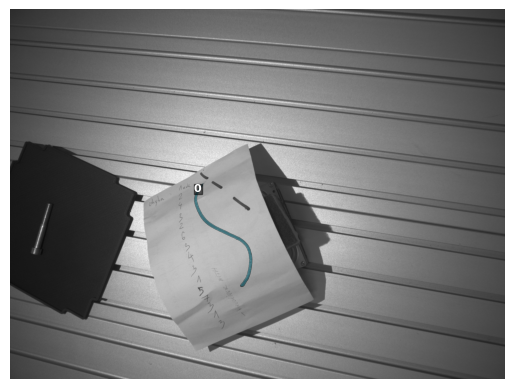

In [15]:
masks = outputs["masks"]
raw_image = Image.open(new_image_path).convert("RGB")
show_masks_on_image(raw_image, masks[30:31])  # Show a subset of masks for clarity

In [16]:
mask = outputs["masks"][30]

(1544, 2064)


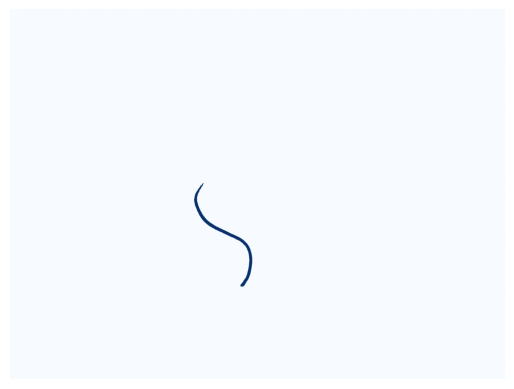

In [ ]:
print(mask.shape)  # Should be (H, W)
# plot mask
plt.imshow(mask, cmap="Blues")
plt.axis("off")
plt.show()

In [22]:
from skimage.morphology import skeletonize


In [113]:
skel = skeletonize(mask.astype(bool)).astype(np.uint8)

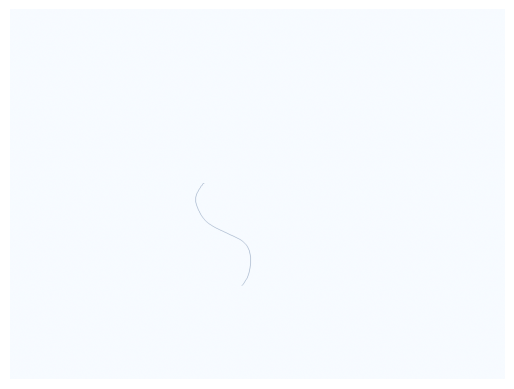

In [114]:
skel.shape  # Should be (H, W)
# skel = np.fliplr(skel) # Flip horizontally to match image orientation
# skel = np.flipud(skel) # Flip vertically to match image orientation


plt.imshow(skel, cmap="Blues")
plt.axis("off")
plt.show()


(1544, 2064)
Number of skeleton coordinates: 501
Simplified skeleton has 18 points.


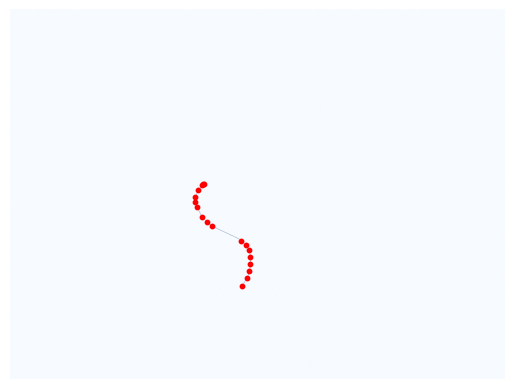

In [124]:
from shapely.geometry import LineString
print(skel.shape)  # Should be (H, W)
ys, xs = np.where(skel > 0)
coords = list(zip(xs, ys)) 
print(f"Number of skeleton coordinates: {len(coords)}")
# print(f"First 10 coordinates: {coords[:10]}")



# Stack xs and ys into (N, 2) array of coordinates
skeleton_coords = np.column_stack((xs, ys))

# Create a LineString object
line = LineString(skeleton_coords)

# Simplify the line using Ramer-Douglas-Peucker algorithm
tolerance = 2.0  # Adjust tolerance as needed
simplified_line = line.simplify(tolerance)

# Get simplified coordinates
simplified_coords = np.array(simplified_line.coords)
print(f"Simplified skeleton has {len(simplified_coords)} points.")
# plot the simplified skeleton
plt.imshow(skel, cmap="Blues")
plt.scatter(simplified_coords[:, 0], simplified_coords[:, 1], color='red', s=10)
plt.axis("off")
plt.show()

In [108]:
import os
from plyfile import PlyData, PlyElement

frames_dir = "/home/robolab2/master_project/frames/"
ply_name = "scan_17.ply"
ply_path = os.path.join(frames_dir, ply_name)
print(f"Loading PLY: {ply_path}")
plydata = PlyData.read(str(ply_path))


Loading PLY: /home/robolab2/master_project/frames/scan_17.ply


In [116]:
points = plydata.elements[0].data[['x', 'y', 'z' , 'nx' , 'ny' , 'nz']]
#convert to numpy array
points = np.array(points.tolist())
print(points.shape)
img_width =  plydata.elements[2].data['frame_width'].item()
img_height = plydata.elements[2].data['frame_height'].item()

reshaped_points = points.reshape((img_height, img_width, 6))
print(reshaped_points.shape)  # Should be (H, W, 6)

(3186816, 6)
(1544, 2064, 6)


In [ ]:
# Get 3D coordinates for skeleton points
skeleton_3d_points = []
for x, y in coords:
    if 0 <= x < img_width and 0 <= y < img_height:
        point_3d = reshaped_points[y, x]  # Note the order: (y, x) for row, column
        skeleton_3d_points.append(point_3d)

skeleton_3d_points_simplified = []
for x, y in simplified_coords:
    x, y = int(round(x)), int(round(y))
    if 0 <= x < img_width and 0 <= y < img_height:
        point_3d = reshaped_points[y, x]
        skeleton_3d_points_simplified.append(point_3d)

skeleton_3d_points = np.array(skeleton_3d_points)
skeleton_3d_points_simplified = np.array(skeleton_3d_points_simplified)

print(skeleton_3d_points.shape)
print(skeleton_3d_points_simplified.shape)


In [ ]:
skeleton_3d_points = np.array(skeleton_3d_points)

print(skeleton_3d_points.shape)

(501, 6)


In [119]:
# save to ply file
# Ensure skeleton_3d_points is a 2D array of shape (N, 6)
vertex = np.zeros(skeleton_3d_points.shape[0], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('nx', 'f4'), ('ny', 'f4'), ('nz', 'f4')])
vertex['x'] = skeleton_3d_points[:, 0]
vertex['y'] = skeleton_3d_points[:, 1]
vertex['z'] = skeleton_3d_points[:, 2]
vertex['nx'] = skeleton_3d_points[:, 3]
vertex['ny'] = skeleton_3d_points[:, 4]
vertex['nz'] = skeleton_3d_points[:, 5]
ply_el = PlyElement.describe(vertex, 'vertex')
ply_output_path = os.path.join(frames_dir, "skeleton_mask_30.ply")
PlyData([ply_el], text=True).write(ply_output_path)

In [130]:
# save simplified_coords to ply file
vertex = np.zeros(skeleton_3d_points_simplified.shape[0], dtype=[('x', 'f4'), ('y', 'f4'), ('z', 'f4'), ('nx', 'f4'), ('ny', 'f4'), ('nz', 'f4')])
vertex['x'] = skeleton_3d_points_simplified[:, 0]
vertex['y'] = skeleton_3d_points_simplified[:, 1]
vertex['z'] = skeleton_3d_points_simplified[:, 2]
vertex['nx'] = skeleton_3d_points_simplified[:, 3]
vertex['ny'] = skeleton_3d_points_simplified[:, 4]
vertex['nz'] = skeleton_3d_points_simplified[:, 5]
ply_el = PlyElement.describe(vertex, 'vertex')
ply_output_path = os.path.join(frames_dir, "skeleton_mask_30_simple.ply")
PlyData([ply_el], text=True).write(ply_output_path)


AttributeError: 'list' object has no attribute 'shape'